HW4

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from random import random

import itertools
import warnings

In [5]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df_m = df.resample('W').mean()

In [6]:
df_m.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [7]:
# функция экспоненциального сглаживания датасета
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [8]:
# функция для подсчёта ошибки модели
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:

# функция разбиения датасета на тестовую и валидационную выборки 
def split_data_b( data, split_date ):
  data = data[['PJME_MW', 'exp_0_01', 't', 't1', 't2']]
  return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
          data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [10]:

df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)

In [11]:
df['t'] = 0
df.iloc[1:,14]=df.iloc[:-1,1].values
df['t1']=0
df.iloc[2:,15]=df.iloc[:-2,1].values
df['t2']=0
df.iloc[3:,16]=df.iloc[:-3,1].values
df.fillna(0)
df = df.drop(['Time'], axis=1)
df.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,exp_0_01,t,t1,t2
Date,,,,,,,,,,,,,,,,
2002-01-01,30393.0,2002,1,1,1,1,1,1,1,1,0,0,30393.000000,0.0,0.0,0.0
2002-01-01,29265.0,2002,1,1,1,1,1,1,2,1,0,0,30381.720000,30393.0,0.0,0.0
2002-01-01,28357.0,2002,1,1,1,1,1,1,3,1,0,0,30361.472800,29265.0,30393.0,0.0
2002-01-01,27899.0,2002,1,1,1,1,1,1,4,1,0,0,30336.848072,28357.0,29265.0,30393.0
2002-01-01,28057.0,2002,1,1,1,1,1,1,5,1,0,0,30314.049591,27899.0,28357.0,29265.0


In [102]:
scl_target=StandardScaler() 
p = 4
h=1
target = df['PJME_MW'].values[h+p:].reshape((df.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(145369, 1)

In [103]:
scl_x=StandardScaler() 

X = df.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(145369, 16)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


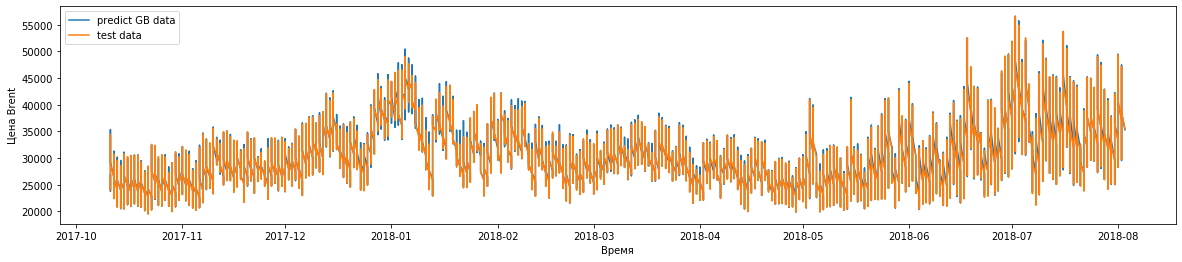

In [12]:

model_gb_h1 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df, '10-10-2017')

h=1
X_train_b_h1 = train_b.iloc[:-h,:]
y_train_b_h1 = train_b[df.columns[0]].values[h:]
X_test_b_h1 = test_b.iloc[:-h,:]
y_test_b_h1 = test_b[df.columns[0]].values[h:]

model_gb_h1.fit( X_train_b_h1, y_train_b_h1 ) 
y_test_pred_gb_h1 = model_gb_h1.predict(X_test_b_h1)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],y_test_pred_gb_h1, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b_h1, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b_h1, y_pred=y_test_pred_gb_h1)

print('ошибка градиентного бустинга :  ', er_g, '%')

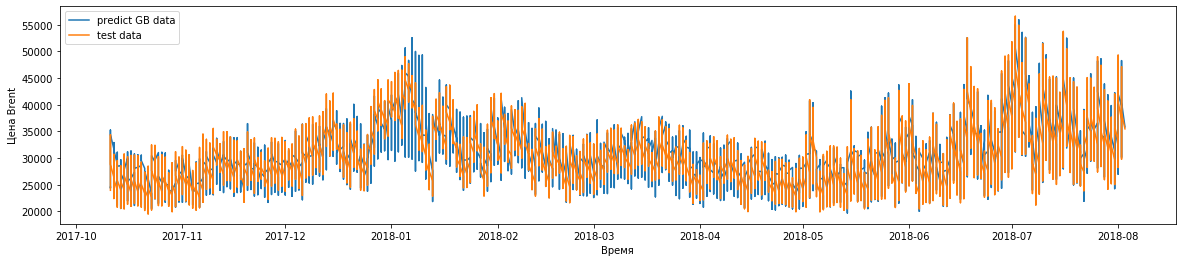

ошибка градиентного бустинга :   5.773828341296543 %


In [86]:

model_gb_h4 = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
train_b, test_b = split_data_b( df, '10-10-2017')

h=4
X_train_b_h4 = train_b.iloc[:-h,:]
y_train_b_h4 = train_b[df.columns[0]].values[h:]
X_test_b_h4 = test_b.iloc[:-h,:]
y_test_b_h4 = test_b[df.columns[0]].values[h:]

model_gb_h4.fit( X_train_b_h4, y_train_b_h4 ) 
y_test_pred_gb_h4 = model_gb_h4.predict(X_test_b_h4)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],y_test_pred_gb_h4, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b_h4, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b_h4, y_pred=y_test_pred_gb_h4)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [121]:
# ['weekofyear', 'diff1_l', 't4', 't1']
def calc_range(x1, x2):
    X_test_100 = X_test_b_h1.values
    y_test_100 = y_test_pred_gb_h1.copy()
    N10 = 10
    for i in range(x1, x2):
        y_test_100[i] = model_gb_h1.predict(X_test_100[i,:].reshape((1,5)))
        # восстанавливаем не масштабированное значение ряда текущей точке  
        y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )

        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #'t4', 't1' автокорреляционные функции Признаки 2 и 3.
        X_test_100[i+1,2] = X_test_100[i,0]
        X_test_100[i+1,3] = X_test_100[i-3,0]
        #'d3', 'd2' автокорреляционные функции Признаки 2 и 3.
        #строим 'diff1_l' - признак под номером 1
        # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
        xy_i=(np.log((y_i))-scl_x.mean_[9])*scl_x.scale_[9]
        #устанавливаем новое значение для 4
        X_test_100[i+1,1] = xy_i 
        
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_pred_gb_h1[x1:x2]),y_pred = scl_target.inverse_transform( y_test_100[x1:x2]))
    print(f'ошибка градиентного бустинга MAPE {x1},{x2} : {er_g} %')

In [122]:
for i in range (10, 90, 10):
    calc_range(i, i+10)

ошибка градиентного бустинга MAPE 10,20 : 19.725524368884408 %
ошибка градиентного бустинга MAPE 20,30 : 12.781276696652588 %
ошибка градиентного бустинга MAPE 30,40 : 4.9008967191781085 %
ошибка градиентного бустинга MAPE 40,50 : 11.492866204563851 %
ошибка градиентного бустинга MAPE 50,60 : 7.233739031428001 %
ошибка градиентного бустинга MAPE 60,70 : 20.347650262380057 %
ошибка градиентного бустинга MAPE 70,80 : 12.619957366317719 %
ошибка градиентного бустинга MAPE 80,90 : 9.645398838048237 %


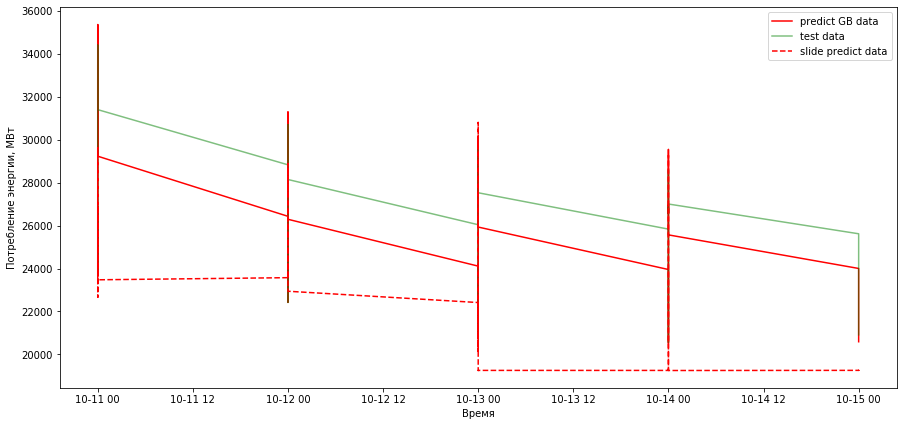

In [123]:
# ['weekofyear', 'diff1_l', 't4', 't1']
X_test_100 = X_test_b_h1.values
y_test_100 = y_test_pred_gb_h1.copy()
N10 = 100
for i in range(N10):
    y_test_100[i] = model_gb_h1.predict(X_test_100[i,:].reshape((1,5)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #'t4', 't1' автокорреляционные функции Признаки 2 и 3.
    X_test_100[i+1,2] = X_test_100[i,0]
    X_test_100[i+1,3] = X_test_100[i-3,0]
    #'d3', 'd2' автокорреляционные функции Признаки 2 и 3.
    #строим 'diff1_l' - признак под номером 1
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[9])*scl_x.scale_[9]
    #устанавливаем новое значение для 4
    X_test_100[i+1,1] = xy_i 
        
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(X_test_b_h1.index[1:N10+1],y_test_pred_gb_h1[:N10], 'r',label='predict GB data' )
plt.plot(X_test_b_h1.index[1:N10+1],test_b["PJME_MW"][:N10], 'g',label='test data', alpha=0.5)
plt.plot(X_test_b_h1.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()    